# Closed-Loop Evaluation
In this notebook you are going to evaluate a CNN-based policy to control the SDV with a protocol named *closed-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully.**

## What is closed-loop evaluation?
In closed-loop evaluation the model is in **full control of the SDV**. At each time step, we predict the future trajectory and then move the AV to the first of the model's predictions. 

We refer to this process with the terms **forward-simulate** or **unroll**.

![closed-loop](../../images/planning/closed-loop.svg)


## What can we use closed-loop evaluation for?
Closed-loop is crucial to asses a model's capabilities before deploying it in the real world. **Ideally, we would test the model on the road in the real world**. However, this is clearly very expensive and scales poorly. Forward-simulation is an attempt to evaluate the system in a setting which is as close as possible to a real road test on the same route.

Differently from open-loop, the model is now in full control of the SDV and predictions are used to compute the future location of the SDV.

## Is closed-loop evaluation enough?
Closed-loop evaluation is an important step forward towards evaluating how our policy would perform on the road. However, it still has some limitations.

The critical one is the **non-reactivity of other traffic participants**. In fact, while the SDV is now controlled by our policy, other actors are still being replayed from the original log. In this setting, a chasing car will not slow down if our policy choses a different speed profile for the SDV, resulting in a rear collision that wouldn't obviously occur in the real world.

For this reason, closed-loop evaluation is only accurate for the first few seconds of forward simulation. This can be mitigated when enough data exists for the task.

### Imports

In [1]:
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset, filter_agents_by_frames
from l5kit.dataset import EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, yaw_as_rotation33
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.planning.utils import detect_collision
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

import os

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/media/data/l5kit-data/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the model

In [3]:
model_path = "/tmp/planning_model.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path).to(device)
model = model.eval()
torch.set_grad_enabled(False)

/home/mpc/anaconda3/envs/l5kit/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/mpc/anaconda3/envs/l5kit/lib/python3.7/site-packages/torch/serialization.py:591: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


## Load the evaluation data
Differently from training and open loop evaluation, this setting is intrinsically sequential. As such, we won't be using any of PyTorch's parallelisation functionalities.

In [4]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


# Define our unroll function and metrics

Our unroll function is actually very simple. At each timestep:
- we **forward the current frame** to our policy;
- we **get the predicted trajectory** from the model;
- we **compute our metrics**;
- if we have not drifted too much from the original data we procede to the next frame;
- otherwise, we reset the AV to the original GT position.

The function returns not only the RGB frames, but also the different types of errors according to multiple metrics.

## Closed-loop metrics
In this setting **metrics are particularly challenging**. In fact, we would like to penalise some of the simulation drift (e.g. going off road or in the opposite lane) while at the same time allow others (e.g. different speed profiles).

### Collisions
Our SDV should avoid collisions with other agents. In this example, we won't distinguish between collisions caused by non-reactivity of other agents and actual collisions, and we will simply report them all categorised by where they occurred (front, rear and side with respect to the AV).

However, if we only considered collisions, our SDV could pass all tests by simply driving off-road or in a different lane.

### Distance from reference trajectory
To address the issue presented above, we require our SDV to loosely stick to the original trajectory in the data. By setting the right threshold on the distance we can allow for different speed profiles and small steerings, while pensalising large deviations like driving off-road.

We can do so by computing the distance between the first predictions from the policy and the corresponding annotated positions in world coordinates.

In [5]:
def unroll_scene(scene_dataset, model, drifting_threshold=10):
    ## prepare return buffers
    images = []
    collisions = []
    driftings = []

    for frame_idx in tqdm(range(len(scene_dataset))):
        data = scene_dataset[frame_idx]
        data_batch = default_collate([data])
        data_batch = {k: v.to(device) for k, v in data_batch.items()}

        result = model(data_batch)
        
        predicted_positions = result["positions"].detach().cpu().numpy().squeeze()
        predicted_yaws = result["yaws"].detach().cpu().numpy().squeeze()

        ## store image
        im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))    
        draw_trajectory(im_ego, transform_points(data["target_positions"], data["raster_from_agent"]), TARGET_POINTS_COLOR)
        draw_trajectory(im_ego, transform_points(predicted_positions, data["raster_from_agent"]), PREDICTED_POINTS_COLOR)
        images.append(im_ego)

        ## compute absolute positions
        pred_positions_m = transform_points(predicted_positions, data["world_from_agent"])
        pred_angles_rad = predicted_yaws + data["yaw"]
        gt_positions_m = transform_points(data["target_positions"], data["world_from_agent"])

        ## detect collisions
        agents_frame = filter_agents_by_frames(scene_dataset.dataset.frames[frame_idx], scene_dataset.dataset.agents)[0]
        collision = detect_collision(data["centroid"], data["yaw"], data["extent"],agents_frame)
        collisions.append(collision)
        if collision[0] != "":
            continue

        ## detect drifting
        drifting = np.linalg.norm(pred_positions_m[0] - gt_positions_m[0]) > drifting_threshold
        driftings.append(drifting)
        if drifting:
            continue

        ## mutate the next frame if we're not at the end of the scene
        frame_mutate_idx = frame_idx + 1
        if frame_mutate_idx < len(scene_dataset):
            scene_dataset.dataset.frames[frame_mutate_idx]["ego_translation"][:2] = pred_positions_m[0]
            scene_dataset.dataset.frames[frame_mutate_idx]["ego_rotation"] = yaw_as_rotation33(pred_angles_rad[0])
    
    return images, collisions, driftings


# Run the unroll function
In this cell, we test our unroll function on a set of scenes from the evaluation set. 

L5Kit comes with a handy function to separate an individual scene from a bigger dataset that we can use to unroll a single scene (or a set) of choice.

In [6]:
# ==== EVAL LOOP
scenes_to_unroll = 10
images, collisions, driftings = [], [], []
for scene_idx in range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//scenes_to_unroll):
    scene_dataset = eval_dataset.get_scene_dataset(scene_idx)
    scene_images, scene_collisions, scene_driftings = unroll_scene(scene_dataset, model)
    images.append(scene_images)
    collisions.append(scene_collisions)
    driftings.append(scene_driftings)

/media/data/l5kit/l5kit/l5kit/dataset/ego.py:166: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
100%|██████████| 249/249 [00:11<00:00, 21.11it/s]


# Quantitative evaluation

## Plotting errors from the closed-loop

We can collect metrics from different scenes and plot them here.

For collision, we have split them into *rear, front* and *side* to better capture the nature of different errors.

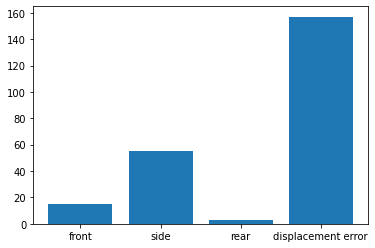

In [7]:
collision_names = np.asarray([collision[0] for scene_collisions in collisions for collision in scene_collisions])
driftings = np.asarray([drift for scene_driftings in driftings for drift in scene_driftings])
values = []
names = []

for collision_name in ["front", "side", "rear"]:
    values.append(np.sum(collision_names == collision_name))
    names.append(collision_name)

values.append(np.sum(driftings == True))
names.append("displacement error")

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names)
plt.show()

# Qualitative evaluation

# Visualise the closed-loop

We can visualise one of the example we have stored in the previous cell. 

**The policy is now in full control of the SDV as this moves through the annotated scene.**

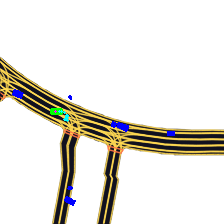

In [8]:
from IPython.display import display, clear_output
import PIL
from time import sleep

for frame in images[0]:
    clear_output(wait=True)
    display(PIL.Image.fromarray(frame))
    sleep(0.05)

# Pre-trained model results

We include here the unroll of one scene using one of our pre-trained model. The controlled SDV can stick to the correct lane and stops successfully for a red light. 

Comparing this result with the one from the [open-loop notebook](./open_loop_test.ipynb) we can notice some differences in the speed profile chosen by the model.


![SegmentLocal](../../images/planning/out_9_closed.gif "segment")
